Dataset loaded: (4269, 13)

Training LogReg_Balanced...
Model: LogReg_Balanced
Precision: 0.9588  Recall: 0.9209  F1: 0.9395  Accuracy: 0.9262
Confusion Matrix:
 [[302  21]
 [ 42 489]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.91       323
           1       0.96      0.92      0.94       531

    accuracy                           0.93       854
   macro avg       0.92      0.93      0.92       854
weighted avg       0.93      0.93      0.93       854


Training DecisionTree_Balanced...
Model: DecisionTree_Balanced
Precision: 0.9777  Recall: 0.9906  F1: 0.9841  Accuracy: 0.9801
Confusion Matrix:
 [[311  12]
 [  5 526]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       323
           1       0.98      0.99      0.98       531

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       

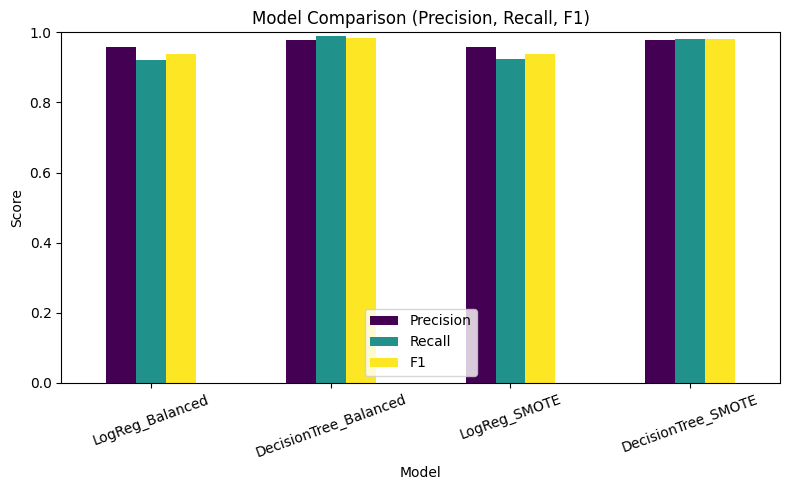

In [1]:
import warnings
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    classification_report, confusion_matrix
)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

warnings.filterwarnings("ignore")

# Helper functions
def infer_target(df):
    candidates = ["Loan_Status", "loan_status", "Approved", "approved", "Status", "status", "Target", "target", "label"]
    for c in candidates:
        if c in df.columns:
            return c
    return df.columns[-1]

def binarize_target(y):
    mapping = {
        "Y": 1, "N": 0, "Yes": 1, "No": 0,
        "Approved": 1, "Rejected": 0,
        1: 1, 0: 0, True: 1, False: 0
    }
    def _map_val(v):
        if pd.isna(v):
            return np.nan
        if isinstance(v, str):
            vs = v.strip()
            if vs in mapping:
                return mapping[vs]
            if vs.lower() in {"y", "yes", "approved", "1", "true"}:
                return 1
            if vs.lower() in {"n", "no", "rejected", "0", "false"}:
                return 0
        return mapping.get(v, v)
    y_mapped = y.map(_map_val)
    uniq = set(y_mapped.dropna().unique())
    if not uniq.issubset({0, 1}):
        codes, _ = pd.factorize(y_mapped)
        return pd.Series((codes == codes.min()).astype(int), index=y.index)
    return y_mapped.astype(int)

def build_preprocessor(X):
    numeric_features = X.select_dtypes(include=["number"]).columns.tolist()
    categorical_features = [c for c in X.columns if c not in numeric_features]

    numeric_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    try:
        # For sklearn >= 1.2
        categorical_pipeline = Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ])
    except TypeError:
        # For sklearn < 1.2
        categorical_pipeline = Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False))
        ])

    return ColumnTransformer([
        ("num", numeric_pipeline, numeric_features),
        ("cat", categorical_pipeline, categorical_features)
    ])


def evaluate_model(name, y_true, y_pred):
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    print("="*70)
    print(f"Model: {name}")
    print(f"Precision: {precision:.4f}  Recall: {recall:.4f}  F1: {f1:.4f}  Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    return {"Model": name, "Precision": precision, "Recall": recall, "F1": f1, "Accuracy": acc}

if __name__ == "__main__":
    # Load dataset
    df = pd.read_csv("/content/loan_approval_dataset.csv")
    print(f"Dataset loaded: {df.shape}")

    # Target column
    target_col = infer_target(df)
    y = binarize_target(df[target_col])
    X = df.drop(columns=[target_col])

    # Remove rows with missing target
    mask = ~y.isna()
    X, y = X[mask].reset_index(drop=True), y[mask].reset_index(drop=True)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Preprocessor
    preprocessor = build_preprocessor(X_train)

    # Models
    models = {
        "LogReg_Balanced": Pipeline([
            ("preprocess", preprocessor),
            ("model", LogisticRegression(max_iter=200, class_weight="balanced"))
        ]),
        "DecisionTree_Balanced": Pipeline([
            ("preprocess", preprocessor),
            ("model", DecisionTreeClassifier(class_weight="balanced", random_state=42))
        ]),
        "LogReg_SMOTE": ImbPipeline([
            ("preprocess", preprocessor),
            ("smote", SMOTE(random_state=42)),
            ("model", LogisticRegression(max_iter=200))
        ]),
        "DecisionTree_SMOTE": ImbPipeline([
            ("preprocess", preprocessor),
            ("smote", SMOTE(random_state=42)),
            ("model", DecisionTreeClassifier(random_state=42))
        ])
    }

    # Train & evaluate
    results = []
    best_model, best_f1 = None, -1
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        metrics = evaluate_model(name, y_test, preds)
        results.append(metrics)
        if metrics["F1"] > best_f1:
            best_f1 = metrics["F1"]
            best_model = (name, model)

    # Save outputs
    results_df = pd.DataFrame(results)
    results_df.to_csv("loan_model_metrics.csv", index=False)
    joblib.dump(best_model[1], "best_loan_model.joblib")
    print(f"\nBest Model: {best_model[0]} with F1={best_f1:.4f}")
    print("Saved metrics to loan_model_metrics.csv")
    print("Saved best model to best_loan_model.joblib")

    # Plot results
    fig, ax = plt.subplots(figsize=(8, 5))
    results_df.set_index("Model")[["Precision", "Recall", "F1"]].plot(
        kind="bar", ax=ax, colormap="viridis"
    )
    plt.title("Model Comparison (Precision, Recall, F1)")
    plt.ylabel("Score")
    plt.xticks(rotation=20)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig("model_comparison_plot.png")
    plt.show()


In [4]:
from sklearn.tree import export_text
import joblib

pipeline = joblib.load("/content/best_loan_model.joblib")

tree_model = pipeline.named_steps["model"]

tree_rules = export_text(tree_model)
print(tree_rules)


|--- feature_5 <= -0.29
|   |--- feature_4 <= -1.03
|   |   |--- feature_3 <= 1.25
|   |   |   |--- feature_2 <= 0.71
|   |   |   |   |--- feature_3 <= 0.37
|   |   |   |   |   |--- feature_7 <= 0.52
|   |   |   |   |   |   |--- feature_2 <= 0.18
|   |   |   |   |   |   |   |--- feature_3 <= -0.54
|   |   |   |   |   |   |   |   |--- feature_8 <= -1.04
|   |   |   |   |   |   |   |   |   |--- feature_1 <= -0.58
|   |   |   |   |   |   |   |   |   |   |--- feature_8 <= -1.19
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- feature_8 >  -1.19
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |--- feature_1 >  -0.58
|   |   |   |   |   |   |   |   |   |   |--- feature_0 <= 1.28
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |   |--- feature_0 >  1.28
|   |   |   |   |   |   |   |   |   |   